In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
#import geoplot as gplt
import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver

from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.utils import *
from Problem.LogDataHandling import *

In [3]:
imgs_path = "../src/imgs"

# Helper functions

In [4]:
def combine_datasets(algorithm_name, log_data_path, parameter_group, datasets=["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]):
    simulations = []
    if type(datasets) == list:
        for dataset_name in datasets:
            try:
                simulation = pd.read_csv("%s%s/%s.csv" % (log_data_path, dataset_name, algorithm_name))
            except:
                print("Error, file not found: %s%s/%s.csv" % (log_data_path, dataset_name, algorithm_name))
                
            simulation = simulation.where(simulation["Parameter Group"] == parameter_group).dropna(how="all")
            simulation["dataset"] = dataset_name
            simulations.append(simulation)
    else:
            try:
                simulation = pd.read_csv("%s%s/%s.csv" % (log_data_path, datasets, algorithm_name))
            except:
                print("Error, file not found: %s%s/%s.csv" % (log_data_path, datasets, algorithm_name))
            
    
            simulation = simulation.where(simulation["Parameter Group"] == parameter_group).dropna(how="all")
            simulation["dataset"] = datasets
            simulations.append(simulation)
        
    
    for df in simulations:
        
        add_final_fitness_columns(df)
        try:
            expand_parameter_colums(df)
        except:
            #print("No parameter columns to expand")
            pass
        add_distance_to_origin(df)
        add_final_compute_time_column(df)
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.fuel_consumption_final)
        df["fuel_consumption_final_mean"] = mean_f0
        df["fuel_consumption_final_min"] = min_f0
        df["fuel_consumption_final_max"] = max_f0
        
        max_fuel_consumption = max(df.fuel_consumption_final)
        min_fuel_consumption = min(df.fuel_consumption_final)
        df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption - min_fuel_consumption)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.fuel_consumption_final_minmax)
        df["fuel_consumption_final_minmax_mean"] = mean_f0
        df["fuel_consumption_final_minmax_min"] = min_f0
        df["fuel_consumption_final_minmax_max"] = max_f0
        
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.longest_route_time_final)
        df["longest_route_time_final_mean"] = mean_f0
        df["longest_route_time_final_min"] = min_f0
        df["longest_route_time_final_max"] = max_f0
        
        max_longest_route_time_final = max(df.longest_route_time_final)
        min_longest_route_time_final = min(df.longest_route_time_final)
        df["longest_route_time_final_minmax"] = (df.longest_route_time_final - min_longest_route_time_final)/(max_longest_route_time_final - min_longest_route_time_final)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.longest_route_time_final_minmax)
        df["longest_route_time_final_minmax_mean"] = mean_f0
        df["longest_route_time_final_minmax_min"] = min_f0
        df["longest_route_time_final_minmax_max"] = max_f0
        
        
        
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.computation_times_final)
        df["computation_times_final_mean"] = mean_f0
        df["computation_times_final_min"] = min_f0
        df["computation_times_final_max"] = max_f0
        
        max_computation_times_final = max(df.computation_times_final)
        min_computation_times_final = min(df.computation_times_final)
        df["computation_times_final_minmax"] = (df.computation_times_final - min_computation_times_final)/(max_computation_times_final - min_computation_times_final)

        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.distance_to_origin)
        df["distance_to_origin_mean"] = mean_f0
        df["distance_to_origin_min"] = min_f0
        df["distance_to_origin_max"] = max_f0
        
        max_distance_to_origin = max(df.distance_to_origin)
        min_distance_to_origin = min(df.distance_to_origin)
        df["distance_to_origin_minmax"] = (df.distance_to_origin - min_distance_to_origin)/(max_distance_to_origin - min_distance_to_origin)
        
        
        
        df["gini_index"] = get_gini_coefficients(df)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.gini_index)
        df["gini_mean"] = mean_f0
        df["gini_min"] = min_f0
        df["gini_max"] = max_f0
        
        df["total_drive_time"] = [sum(x)/(60) for x in df.vehicle_route_time]
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.total_drive_time)
        df["total_drive_time_mean"] = mean_f0
        df["total_drive_time_min"] = min_f0
        df["total_drive_time_max"] = max_f0
        
        df["vehicle_amount"] = [len(x) for x in df.vehicle_route_time]
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.total_drive_time)
        df["vehicle_amount_mean"] = mean_f0
        df["vehicle_amount_min"] = min_f0
        df["vehicle_amount_max"] = max_f0
        
        
        
        
        
    return pd.concat(simulations)

def _mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), sp.stats.sem(a)
    h = se * sp.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def find_fithess_within_percentage_df(dataframe,percentage):
    time_points=[]
    for index,row in dataframe.iterrows():
        final_val = row.fuel_consumption_final
        worst_value_index = np.argsort(row.fuel_consumption)[-1] 

        percentage_range_value = final_val * (1 + percentage)
        if (worst_value := np.array(row.fuel_consumption)[worst_value_index])  < percentage_range_value:
                percentage_range_value = worst_value 

        if final_val == worst_value:
            time_points.append(np.array(row.computation_times)[0])
            continue

        within_range = np.argwhere(np.diff(np.sign(percentage_range_value - np.array(row.fuel_consumption)))).flatten()
        result = list(filter(lambda x: x >= worst_value_index,within_range))[0]
        time_points.append(np.array(row.computation_times)[result])
    return time_points





def add_final_compute_time_column(dataframe):
    if not "computation_times_final" in dataframe.columns:
        if type(dataframe.computation_times.iloc[0]) == str:
            dataframe.computation_times = dataframe.computation_times.apply(literal_eval)
        
        
        dataframe["computation_times_final"] = find_fithess_within_percentage_df(dataframe,0.05)#[dataframe.computation_times.loc[i][-1] for i in list(dataframe.index)]




def plot_3d_minmax(datapoints, labels, third_axis = "time",marker_kwargs={"SA":{"color":"#1f77b4", "marker":"o"}, "NSGA-II": {"color":"#ff7f0e", "marker":"P"}, "NSGA-III":{"color":"#2ca02c", "marker":"s"}, "IBEA":{"color":"#d62728", "marker":"D"}, "IBEA-Adaptive":{"color":"#9467bd", "marker":">"}, "UNSGA-III":{"color":"#8c564b", "marker":"X"}, "GA":{"color":"#e377c2", "marker":"p"}}):
    
    
    plt.style.use("../src/style/custom-seaborn-3dplot.mplstyle")
    fig,ax = plt.subplots(1,1,subplot_kw={"projection": "3d"})
    for data, label in zip(datapoints, labels):


        mean_f0,min_f0,max_f0 =  data.fuel_consumption_final_mean, data.fuel_consumption_final_min, data.fuel_consumption_final_max
        mean_f1,min_f1,max_f1 =  data.total_drive_time_mean  , data.total_drive_time_min, data.total_drive_time_max
        
        
        if third_axis == "time":
            mean_f2,min_f2,max_f2 =  data.computation_times_final_mean, data.computation_times_final_min, data.computation_times_final_max
            third_axis_label = ""
        elif third_axis == "gini":
            mean_f2,min_f2,max_f2 = data.gini_mean, data.gini_min, data.gini_max
            
        #print(mean_f1,min_f1,max_f1)
        ax.plot([min_f0,max_f0],[mean_f1,mean_f1],[mean_f2,mean_f2],zorder=1, c="k")
        ax.plot([mean_f0,mean_f0],[min_f1,max_f1],[mean_f2,mean_f2],zorder=1, c="k")
        ax.plot([mean_f0,mean_f0],[mean_f1,mean_f1],[min_f2,max_f2],zorder=1, c="k")
        
        if third_axis == "time":
            plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}\nCT - {} - $\mu$:{} - {}".format(
                                                                                 round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                                 round(min_f1,2),round(mean_f1,2),round(max_f1,2),
                                                                                 round(min_f2,2),round(mean_f2,2),round(max_f2,2))
        elif third_axis == "gini":
            plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}\nGini - {} - $\mu$:{} - {}".format(
                                                                                 round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                                 round(min_f1,1),round(mean_f1,1),round(max_f1,1),
                                                                                 round(min_f2,2),round(mean_f2,2),round(max_f2,2))
        

        
        ax.scatter(xs= mean_f0, ys=mean_f1, zs=mean_f2, label=plotlabel, s=250, **marker_kwargs[label], zorder=2)
        
    return fig, ax


def plot_3d_minmax_scaled(datapoints, labels, show_mean_eval=False, marker_kwargs={"SA":{"color":"#1f77b4", "marker":"o"}, "NSGA-II": {"color":"#ff7f0e", "marker":"P"}, "NSGA-III":{"color":"#2ca02c", "marker":"s"}, "IBEA":{"color":"#d62728", "marker":"D"}, "IBEA-Adaptive":{"color":"#9467bd", "marker":">"}, "UNSGA-III":{"color":"#8c564b", "marker":"X"}, "GA":{"color":"#e377c2", "marker":"p"}}):
    
    
    plt.style.use("../src/style/custom-seaborn-3dplot.mplstyle")
    fig,ax = plt.subplots(1,1,subplot_kw={"projection": "3d"})
    for data, label in zip(datapoints, labels):

        #fuel_consumptions = np.array(data.fuel_consumption_final)#np.array( [x[0] for x in data.fitness_final])
        #drive_times = data.vehicle_route_time
        #compute_times = np.array(data.optimal_time)
        
        mean_f0,min_f0,max_f0 =  data.fuel_consumption_final_minmax_mean, data.fuel_consumption_final_minmax_min, data.fuel_consumption_final_minmax_max
        mean_f1,min_f1,max_f1 =  data.longest_route_time_final_minmax_mean, data.longest_route_time_final_minmax_min, data.longest_route_time_final_minmax_max
        mean_f2,min_f2,max_f2 =  data.computation_times_final_mean, data.computation_times_final_min, data.computation_times_final_max
        
        #print(mean_f1,min_f1,max_f1)
        ax.plot([min_f0,max_f0],[mean_f1,mean_f1],[mean_f2,mean_f2],zorder=1, c="k")
        ax.plot([mean_f0,mean_f0],[min_f1,max_f1],[mean_f2,mean_f2],zorder=1, c="k")
        ax.plot([mean_f0,mean_f0],[mean_f1,mean_f1],[min_f2,max_f2],zorder=1, c="k")
        if show_mean_eval:
            plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}\nCT - {} - $\mu$:{} - {}\nMean Evaluations: {}".format(
                                                                                     round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                                     round(min_f1,2),round(mean_f1,2),round(max_f1,2),
                                                                                     round(min_f2,2),round(mean_f2,2),round(max_f2,2), round(data.num_evaluations))
        else:
            plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}\nCT - {} - $\mu$:{} - {}".format(
                                                                         round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                         round(min_f1,2),round(mean_f1,2),round(max_f1,2),
                                                                         round(min_f2,2),round(mean_f2,2),round(max_f2,2))
        
        ax.scatter(xs= mean_f0, ys=mean_f1, zs=mean_f2, label=plotlabel, s=250, **marker_kwargs[label], zorder=2)
        # ax.scatter(xs= mean_f0,ys=mean_f1,zs=mean_f2,label=plotlabel,s=200,marker=marker,zorder=2,color=sns.color_palette("deep",10)[1])
    return fig, ax


In [114]:
def plot_vehicle_drivetimes(dataframe,dataset):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig, ax = plt.subplots(1,1)

    dataframe_parameter_group = dataframe.where(dataframe.dataset == dataset).dropna()
    
    if type(dataframe_parameter_group.vehicle_route_time.iloc[0]) == str:
        dataframe_parameter_group.vehicle_route_time = dataframe_parameter_group.vehicle_route_time.apply(literal_eval)
        
    dataframe_parameter_group["vehicle_amount"] = dataframe_parameter_group.vehicle_route_time.apply(lambda x: len(x))
    
    vehicle_amounts = sorted(dataframe_parameter_group.vehicle_amount.unique())
    max_vehicle_amount = vehicle_amounts[-1]
    num_bars = len(vehicle_amounts)
    offsets = np.linspace(-num_bars/12, num_bars/12, num_bars)
    
    for vehicle_amount,offset in zip(vehicle_amounts,offsets):
        vehicle_amount_df = dataframe_parameter_group.where(dataframe_parameter_group.vehicle_amount == vehicle_amount).dropna()
        
        vehicle_amount_route_times = np.stack(vehicle_amount_df.vehicle_route_time.apply(lambda x: np.sort(x)[::-1]/60).to_numpy())
        vehicle_route_times_mean = np.mean(vehicle_amount_route_times,axis=0)
        mean_route_time_sum = int(np.round(sum(vehicle_route_times_mean),0))
        plt.bar(np.arange(vehicle_amount) + offset,vehicle_route_times_mean,width=0.2,alpha=0.5,label=r"$\bf{%s}\ Vehicles:\ %s min$" % (vehicle_amount, mean_route_time_sum))
    plt.xticks(ticks=range(0,max_vehicle_amount),labels=range(1,max_vehicle_amount+1))
    plt.ylabel("Drive Time (minutes)",fontsize=42)
    plt.xlabel("Vehicle nr",fontsize=42)
    plt.legend(fontsize=32)
        
    

In [102]:
def add_minmax_fuel_drivetime_columns(dataframes):
    max_fuel_consumptions = {}
    min_fuel_consumptions = {}
    max_drivetimes = {}
    min_drivetimes = {}
    for dataframe in dataframes:
        datasets = dataframe.dataset.unique()
        for dataset in datasets:
            if not dataset in max_fuel_consumptions.keys():
                max_fuel_consumptions[dataset] = 0
                min_fuel_consumptions[dataset]  = 10e10
                max_drivetimes[dataset]  = 0
                min_drivetimes[dataset]  = 10e10
            
            
            
            dataframe_max_fuel = dataframe.where(dataframe.dataset == dataset).dropna().fuel_consumption_final.max()
            dataframe_min_fuel = dataframe.where(dataframe.dataset == dataset).dropna().fuel_consumption_final.min()
            
            dataframe_max_drivetime = dataframe.where(dataframe.dataset == dataset).dropna().longest_route_time_final.max()
            dataframe_min_drivetime = dataframe.where(dataframe.dataset == dataset).dropna().longest_route_time_final.min()
            
            if dataframe_max_fuel > max_fuel_consumptions[dataset]:
                max_fuel_consumptions[dataset] = dataframe_max_fuel
                
            if dataframe_min_fuel < min_fuel_consumptions[dataset]:
                min_fuel_consumptions[dataset] = dataframe_min_fuel
                
            if dataframe_max_drivetime > max_drivetimes[dataset]:
                max_drivetimes[dataset] = dataframe_max_drivetime
                
            if dataframe_min_drivetime < min_drivetimes[dataset]:
                min_drivetimes[dataset] = dataframe_min_drivetime
                
    
    for dataframe in dataframes:
        datasets = dataframe.dataset.unique()
        for dataset in datasets:
            max_fuel_consumption = max_fuel_consumptions[dataset]
            min_fuel_consumption = min_fuel_consumptions[dataset]
            
            max_longest_route_time_final = max_drivetimes[dataset]
            min_longest_route_time_final = min_drivetimes[dataset]
            
            dataframe_fuel_consumption_scaled = (dataframe.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption - min_fuel_consumption)

            dataframe['fuel_consumption_final_minmax'] = np.where((dataframe.dataset == dataset),dataframe_fuel_consumption_scaled,dataframe.fuel_consumption_final_minmax)
            
            dataframe_longest_drivetime_scaled = (dataframe.longest_route_time_final - min_longest_route_time_final)/(max_longest_route_time_final - min_longest_route_time_final)
            dataframe['longest_route_time_final_minmax'] = np.where((dataframe.dataset == dataset),dataframe_longest_drivetime_scaled,dataframe.longest_route_time_final_minmax)
      
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(dataframe.fuel_consumption_final_minmax)
        dataframe["fuel_consumption_final_minmax_mean"] = mean_f0
        dataframe["fuel_consumption_final_minmax_min"] = min_f0
        dataframe["fuel_consumption_final_minmax_max"] = max_f0

        mean_f0, min_f0, max_f0 = _mean_confidence_interval(dataframe.longest_route_time_final_minmax)
        dataframe["longest_route_time_final_minmax_mean"] = mean_f0
        dataframe["longest_route_time_final_minmax_min"] = min_f0
        dataframe["longest_route_time_final_minmax_max"] = max_f0
        

In [103]:
def plot_2d_minmax_scaled(datapoints, labels, show_mean_eval=False, minmax_scale = True,marker_kwargs={"SA":{"color":"#1f77b4", "marker":"o"}, "NSGA-II": {"color":"#ff7f0e", "marker":"P"}, "NSGA-III":{"color":"#2ca02c", "marker":"s"}, "IBEA":{"color":"#d62728", "marker":"D"}, "IBEA-Multiobjective":{"color":"#9467bd", "marker":">"}, "UNSGA-III":{"color":"#8c564b", "marker":"X"}, "GA":{"color":"#e377c2", "marker":"p"}}):
    
    marker_kwargs["SA-D&C"] = {"color":"#8c564b", "marker":"o"}
    marker_kwargs["IBEA-D&C"] = {"color":"#ff7f0e", "marker":"D"}
    marker_kwargs["NSGA-III-D&C"] = {"color":"#e377c2", "marker":"s"}
    
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig,ax = plt.subplots(1,1)
    for data, label in zip(datapoints, labels):

        if minmax_scale:
            mean_f0,min_f0,max_f0 =  data.fuel_consumption_final_minmax_mean, data.fuel_consumption_final_minmax_min, data.fuel_consumption_final_minmax_max
            mean_f1,min_f1,max_f1 =  data.longest_route_time_final_minmax_mean, data.longest_route_time_final_minmax_min, data.longest_route_time_final_minmax_max
        else:
            mean_f0,min_f0,max_f0 =  data.fuel_consumption_final_mean, data.fuel_consumption_final_min, data.fuel_consumption_final_max
            mean_f1,min_f1,max_f1 = data.total_drive_time_mean  , data.total_drive_time_min, data.total_drive_time_max
            
            
            
        if "D&C" in label:
            ax.plot([min_f0,max_f0],[mean_f1,mean_f1],zorder=1, c="k", linestyle="dotted")
            ax.plot([mean_f0,mean_f0],[min_f1,max_f1],zorder=1, c="k", linestyle="dotted")
        else:
            ax.plot([min_f0,max_f0],[mean_f1,mean_f1],zorder=1, c="k", linestyle="--")
            ax.plot([mean_f0,mean_f0],[min_f1,max_f1],zorder=1, c="k", linestyle="--")
            
        if minmax_scale:
            plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}".format(
                                                                                         round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                                         round(min_f1,2),round(mean_f1,2),round(max_f1,2))
        else:
            


            if show_mean_eval:
                plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {} \nMean Evaluations: {}".format(
                                                                                         round(min_f0,1),round(mean_f0,1),round(max_f0,1),
                                                                                         int(round(min_f1,0)),int(round(mean_f1,0)),int(round(max_f1,0)), round(data.num_evaluations))
            else:
                plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}".format(
                                                                             round(min_f0,1),round(mean_f0,1),round(max_f0,1),
                                                                             round(min_f1,1),round(mean_f1,1),round(max_f1,1))

        ax.scatter(x= mean_f0, y=mean_f1, label=plotlabel, s=250, **marker_kwargs[label], zorder=2)
    return fig, ax

In [111]:
from sympy import symbols, solve,Eq
def get_pareto_line(algorithms,xlim,ylim):
    best_sol = list(sorted(algorithms,key=lambda x: x.fuel_consumption_final_mean + x.total_drive_time_mean))[0]
    best_obj_sum =  best_sol.fuel_consumption_final+best_sol.total_drive_time_mean#best_sol.objective_sum
    best_obj_x =  best_sol.fuel_consumption_final
    best_obj_y =  best_sol.total_drive_time_mean
    
    x0,x1 = xlim
    y0,y1 = ylim
    test_x = best_obj_sum - y0
    
    k = (best_obj_y-y0)/(best_obj_x-test_x)
    m = best_obj_y- (best_obj_x*k)
    
    point_2_x = symbols('x')
    expr = (point_2_x*k) + m
    sol = solve(expr)
    point_1 = (0,m)
    point_2 = (sol[0],0) 
    return point_1,point_2

In [112]:
import time 
start_time = time.monotonic()
print("NSGA2")
NSGA2_data_evaluation_limited = combine_datasets("NSGA2", "parameter_data/multi_objective/",parameter_group=35)
print("NSGA3")
NSGA3_data_evaluation_limited = combine_datasets("NSGA3", "parameter_data/multi_objective/",parameter_group=44)
print("UNSGA3")
UNSGA3_data_evaluation_limited = combine_datasets("UNSGA3", "parameter_data/multi_objective/",parameter_group=44)
print("IBEA")
IBEA_data_evaluation_limited = combine_datasets("IBEA", "parameter_data/multi_objective/",parameter_group=35)
#add_minmax_fuel_drivetime_columns([NSGA2_data_evaluation_limited,NSGA3_data_evaluation_limited,
#                                   UNSGA3_data_evaluation_limited,IBEA_data_evaluation_limited])
#NSGA2_data_evaluation_limited_mean = NSGA2_data_evaluation_limited.mean()
#NSGA3_data_evaluation_limited_mean = NSGA3_data_evaluation_limited.mean()
#UNSGA3_data_evaluation_limited_mean = UNSGA3_data_evaluation_limited.mean()
#IBEA_data_evaluation_limited_mean = IBEA_data_evaluation_limited.mean()
print("Time: ", time.monotonic() - start_time)

NSGA2
NSGA3
UNSGA3
IBEA
Time:  9.602554460998363


# Plot

In [144]:
def get_algorithm_coordinates(algorithms):
    coordinates = [[0,0]]
    
    for algorithm in algorithms:
        coordinates.append([algorithm.fuel_consumption_final,algorithm.total_drive_time])
    return coordinates

In [145]:
get_algorithm_coordinates(algorithms)

[[0, 0],
 [71.90447769139833, 554.7211111111111],
 [71.78144359256932, 550.0594444444446],
 [73.08261764015417, 558.4544444444443],
 [72.75525916520259, 560.765]]

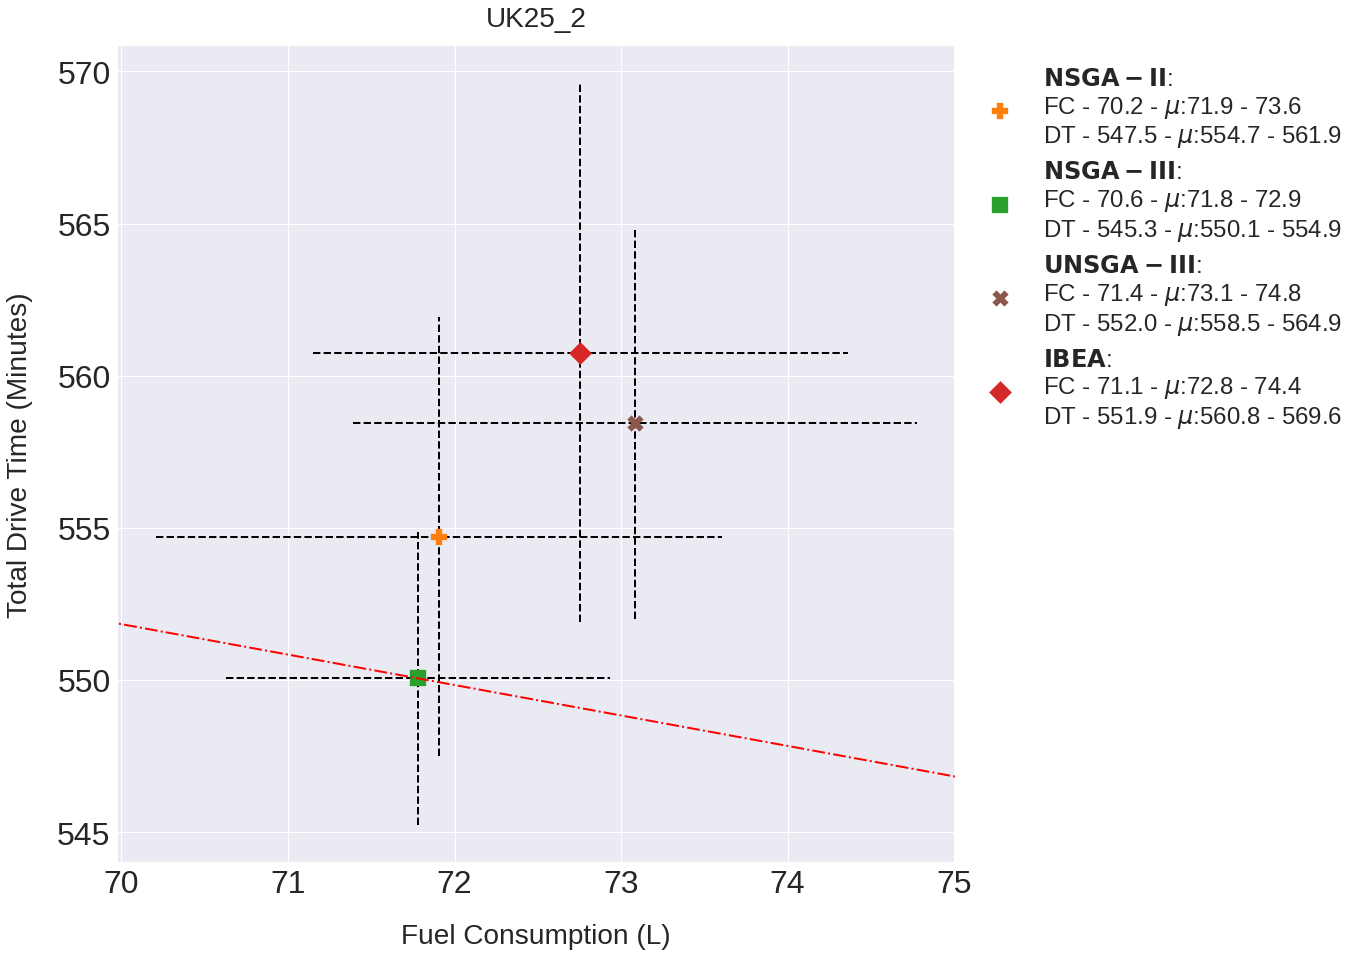

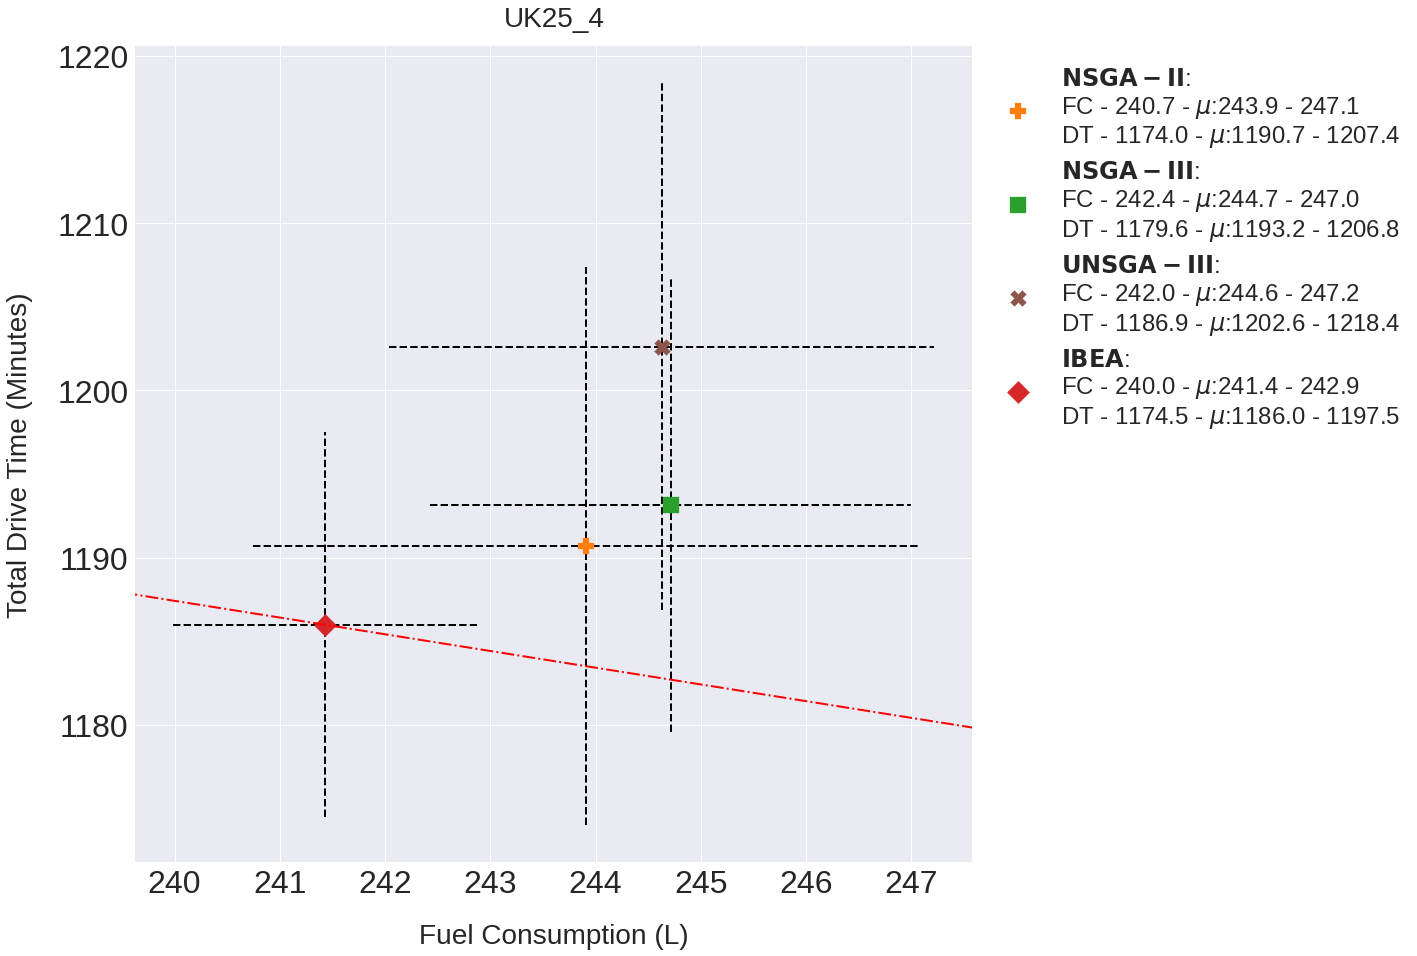

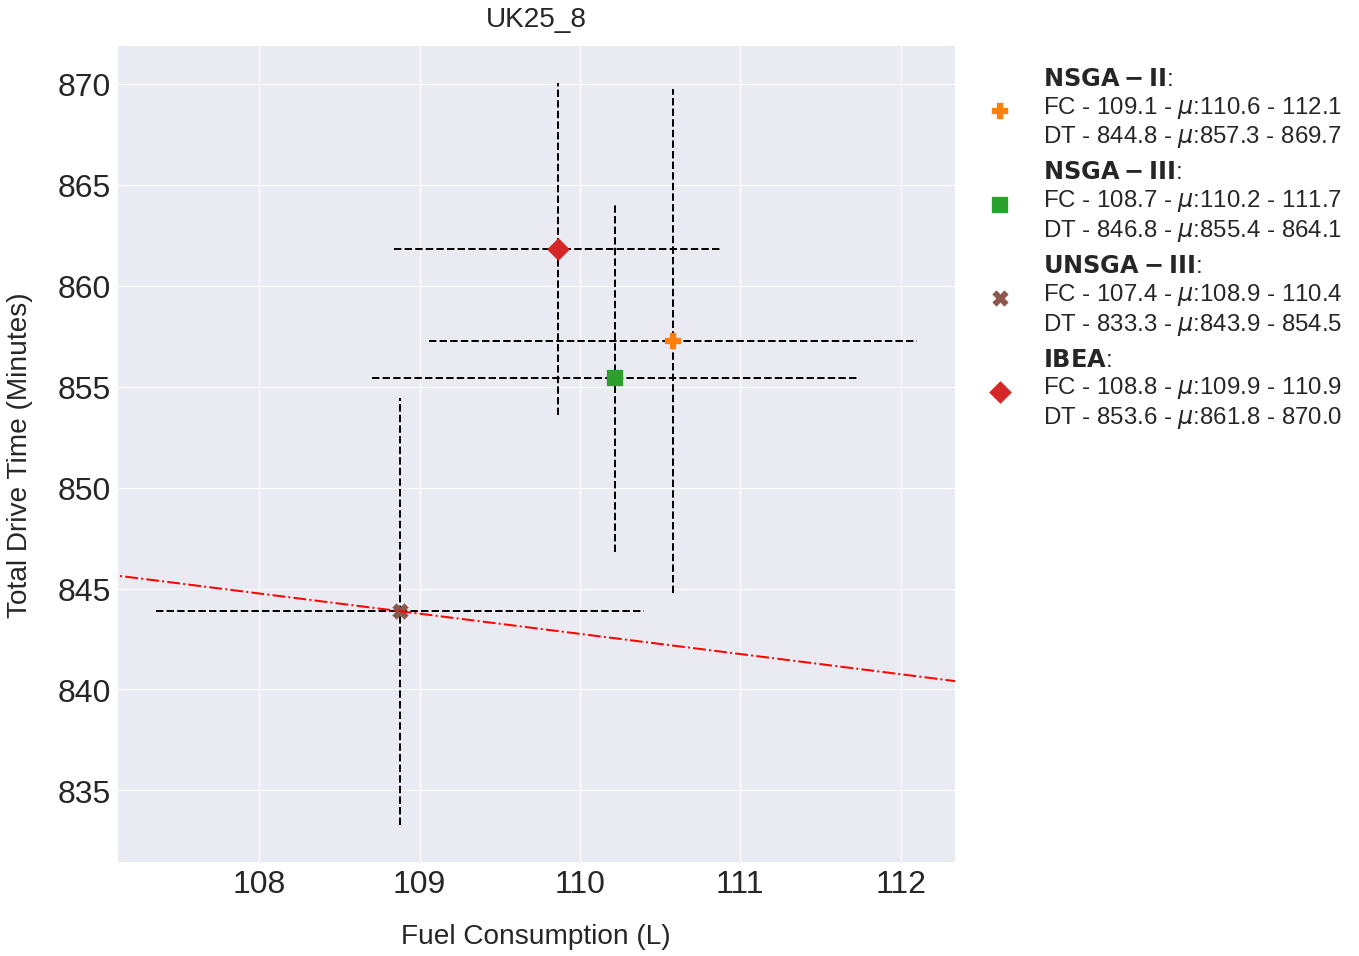

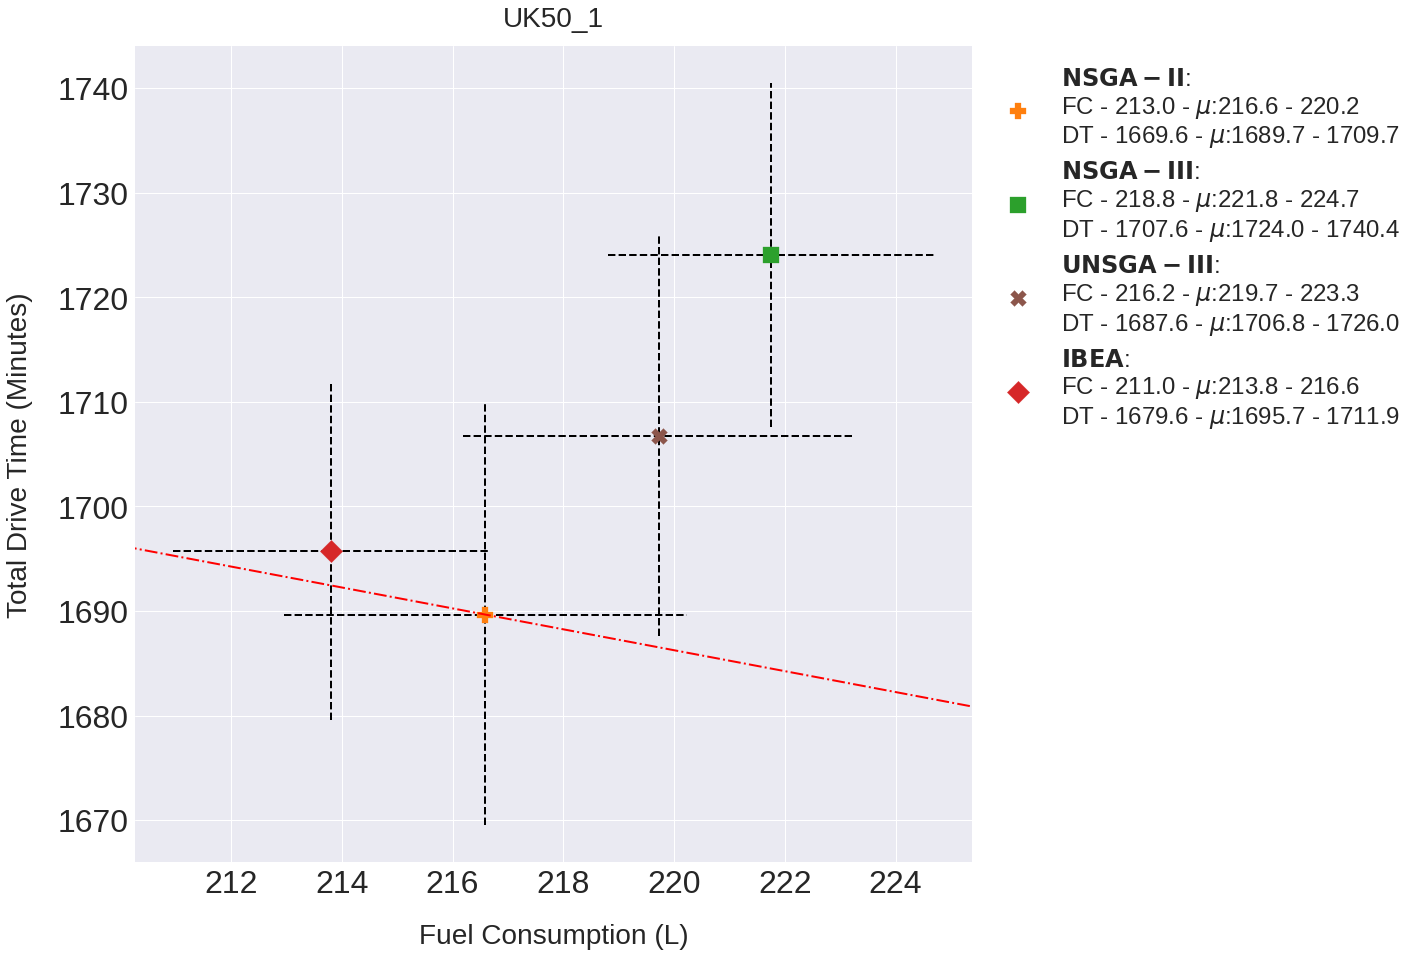

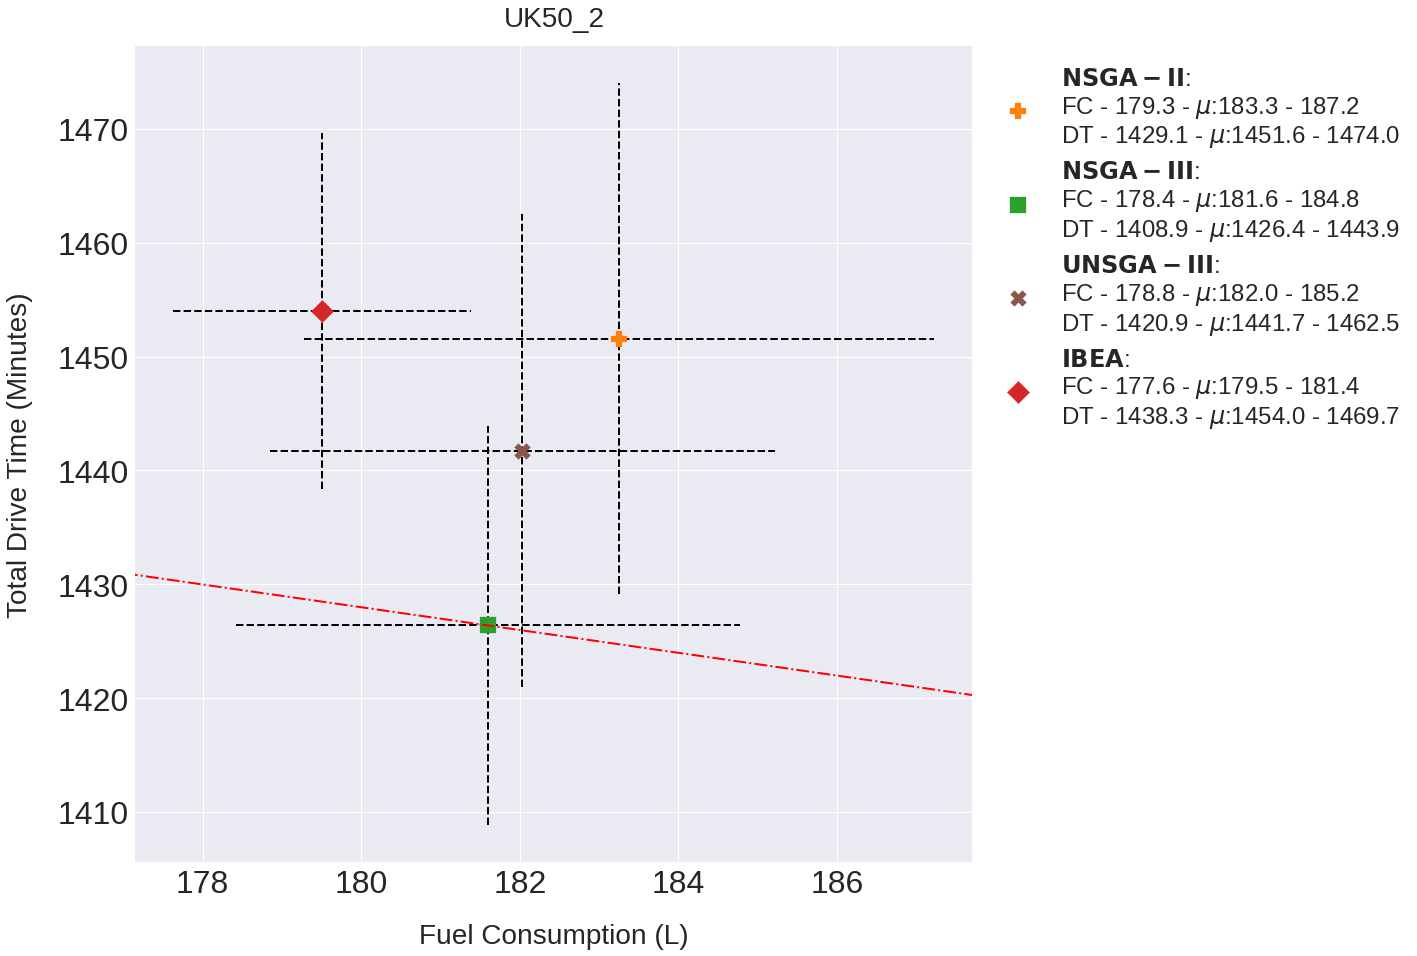

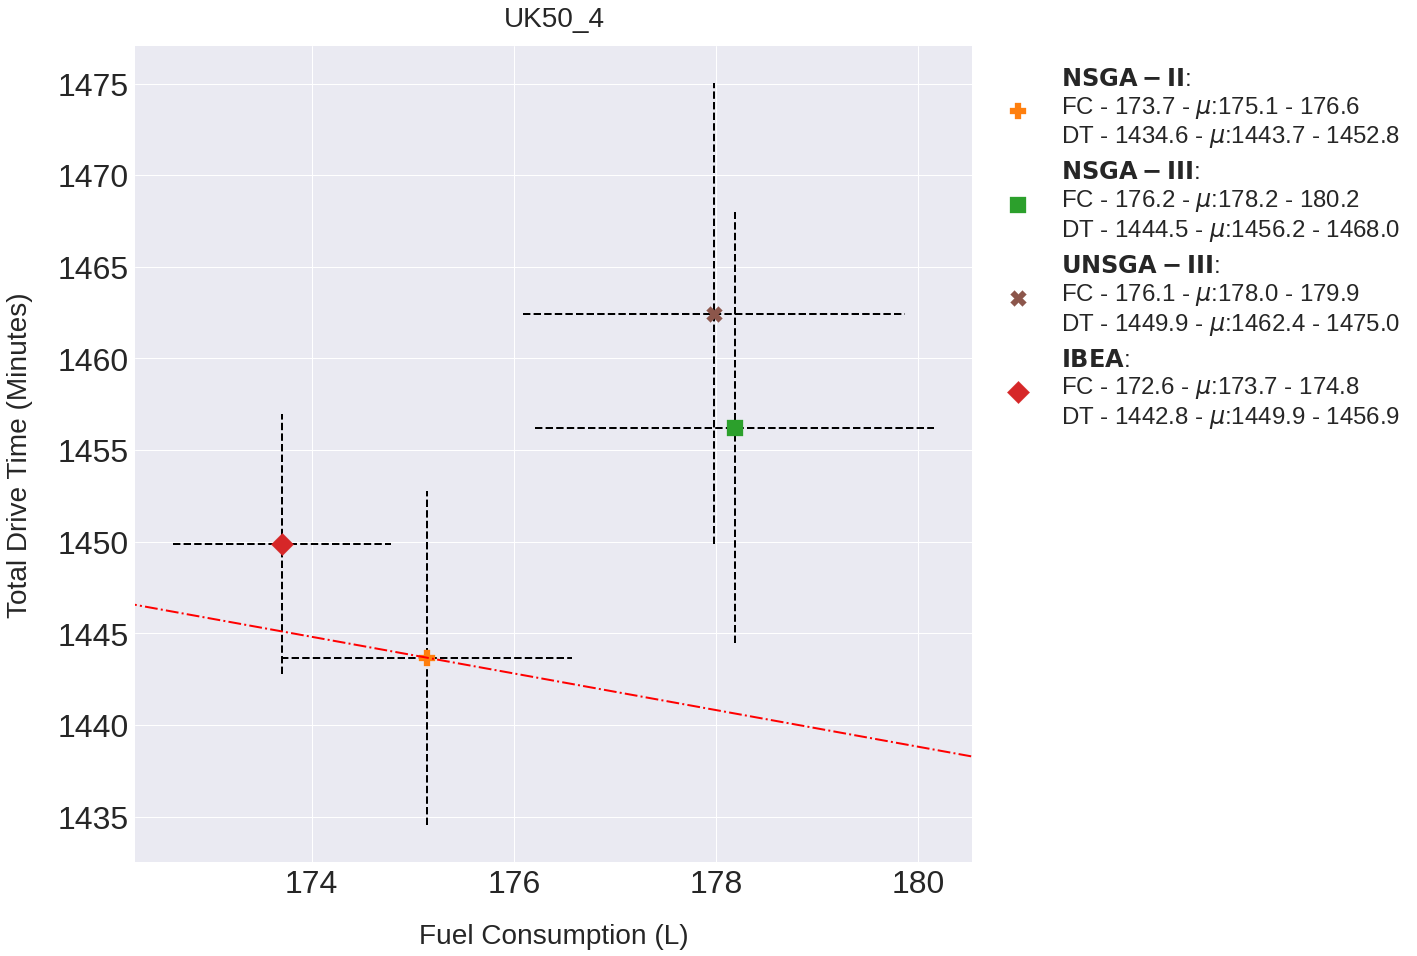

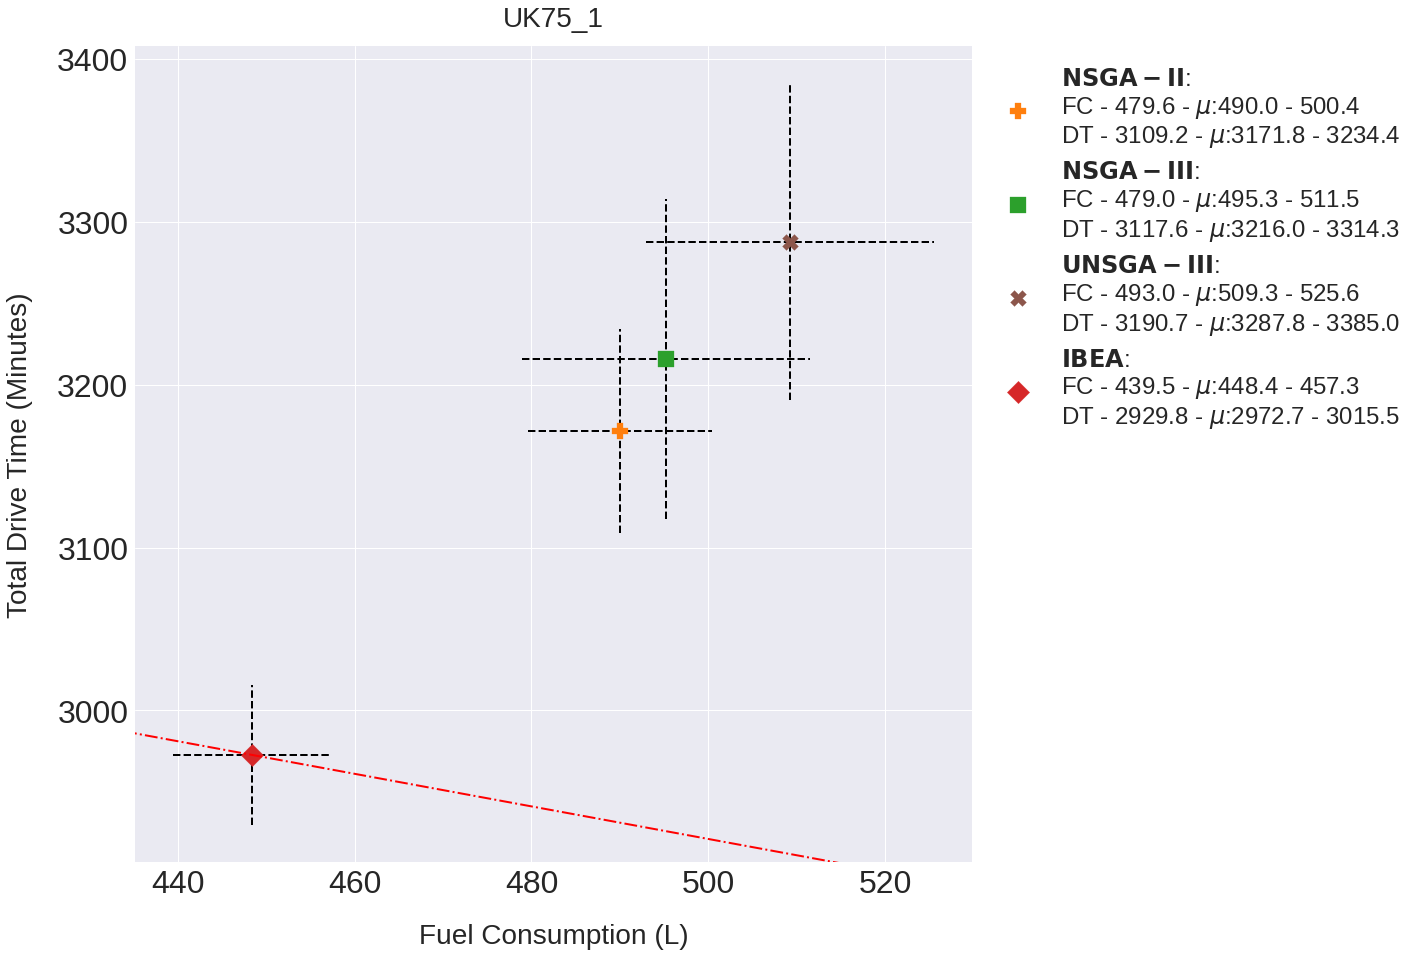

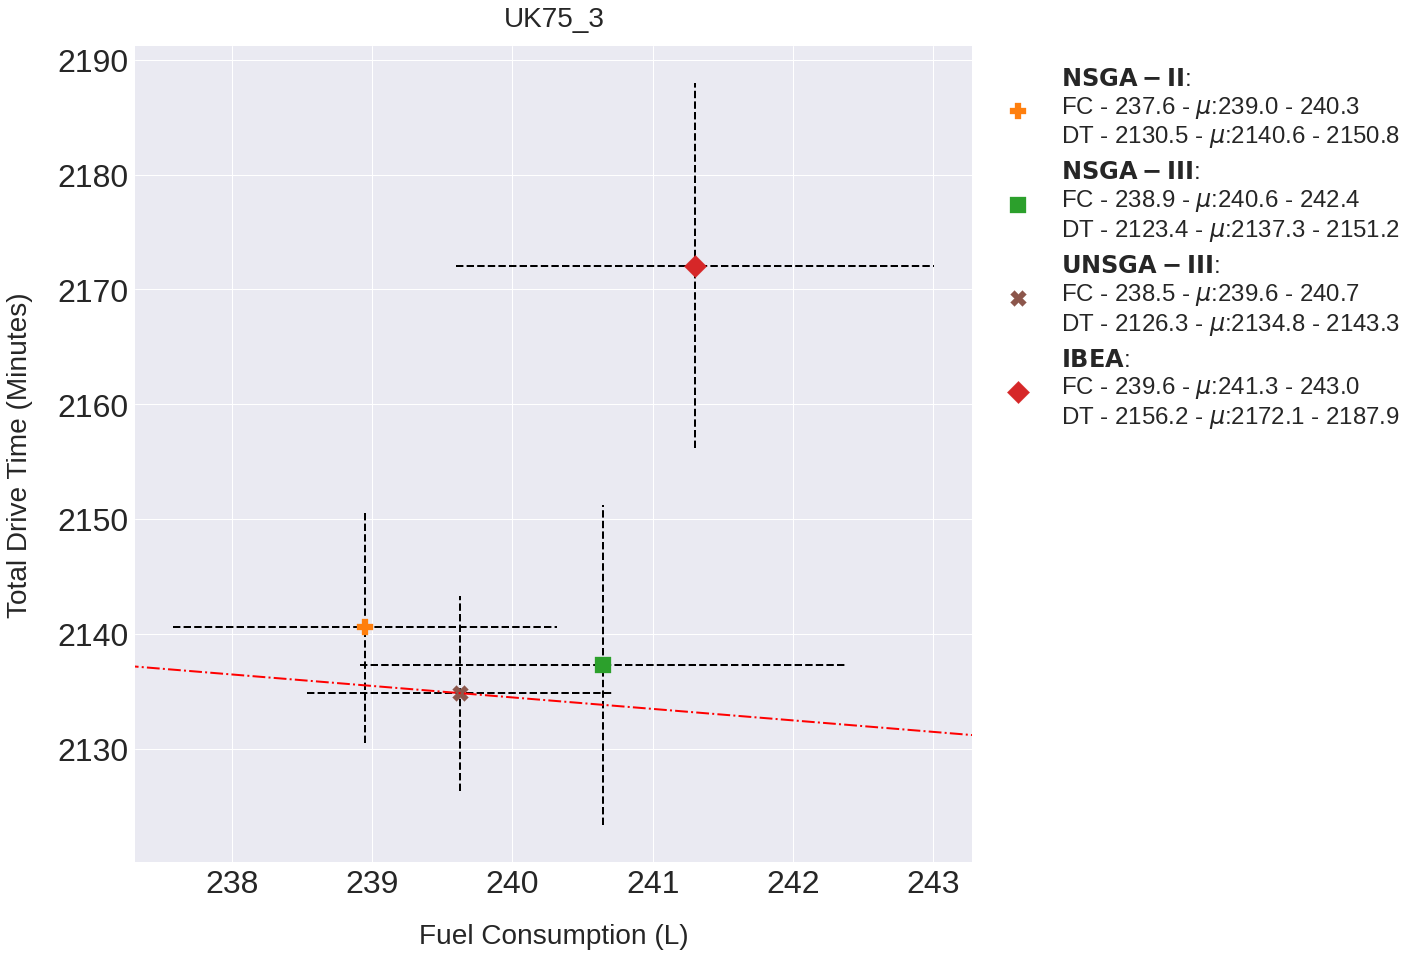

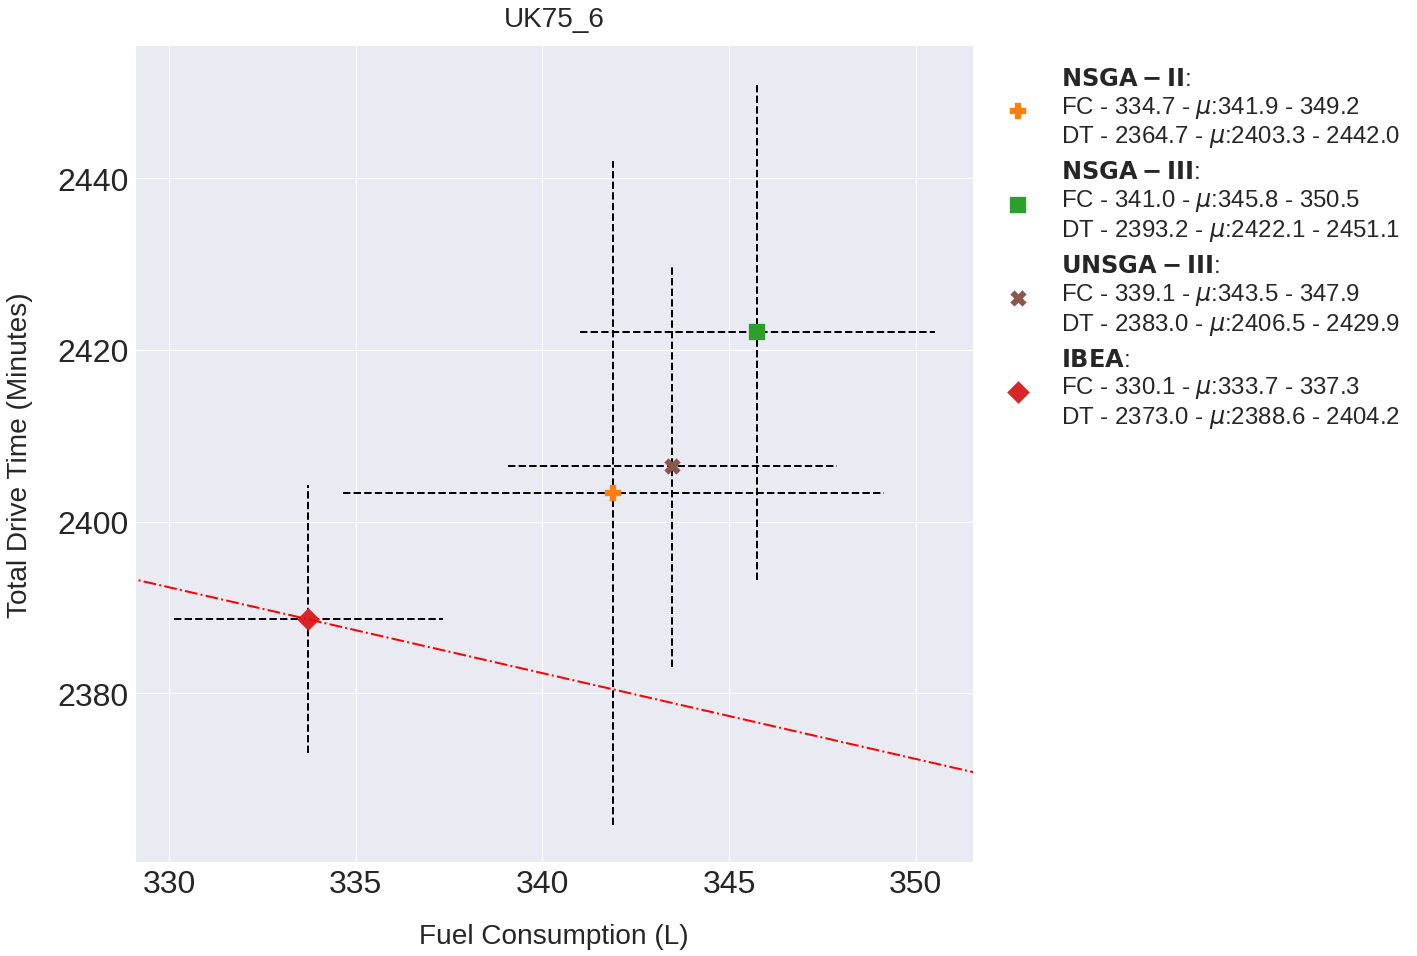

In [153]:
from scipy import interpolate
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
for dataset in dataset_names:
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    #print(NSGA2_data_dataset)
    algorithms = [NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset]
    
    labels = ["NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
    fig, ax = plot_2d_minmax_scaled(algorithms, labels, show_mean_eval=False,minmax_scale=False)
    
    x0,x1 = plt.xlim()
    y0,y1 = plt.ylim()
    point_1,point_2 = get_pareto_line(algorithms,plt.xlim(),plt.ylim()) 
     
    
    points = np.array([point_1,point_2])
  
    plt.plot(points[:,0],points[:,1],linestyle="dashdot",c="red")

    ax.set_ylim(y0,y1)
    ax.set_xlim(x0,x1)
    
    
    
    
    
    
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title(dataset)
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Total Drive Time (Minutes)",labelpad=24)
    plt.show()

array([71.90447769, 71.78144359, 73.08261764, 72.75525917])

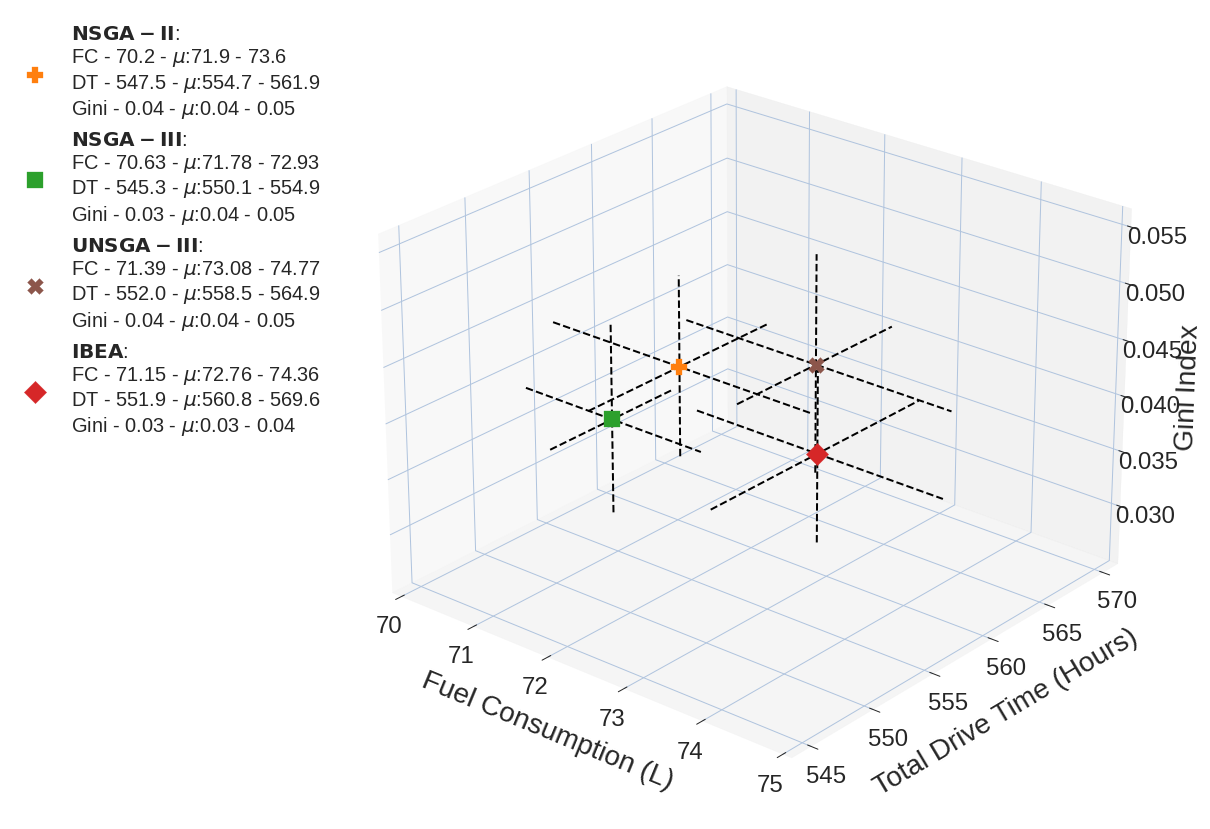

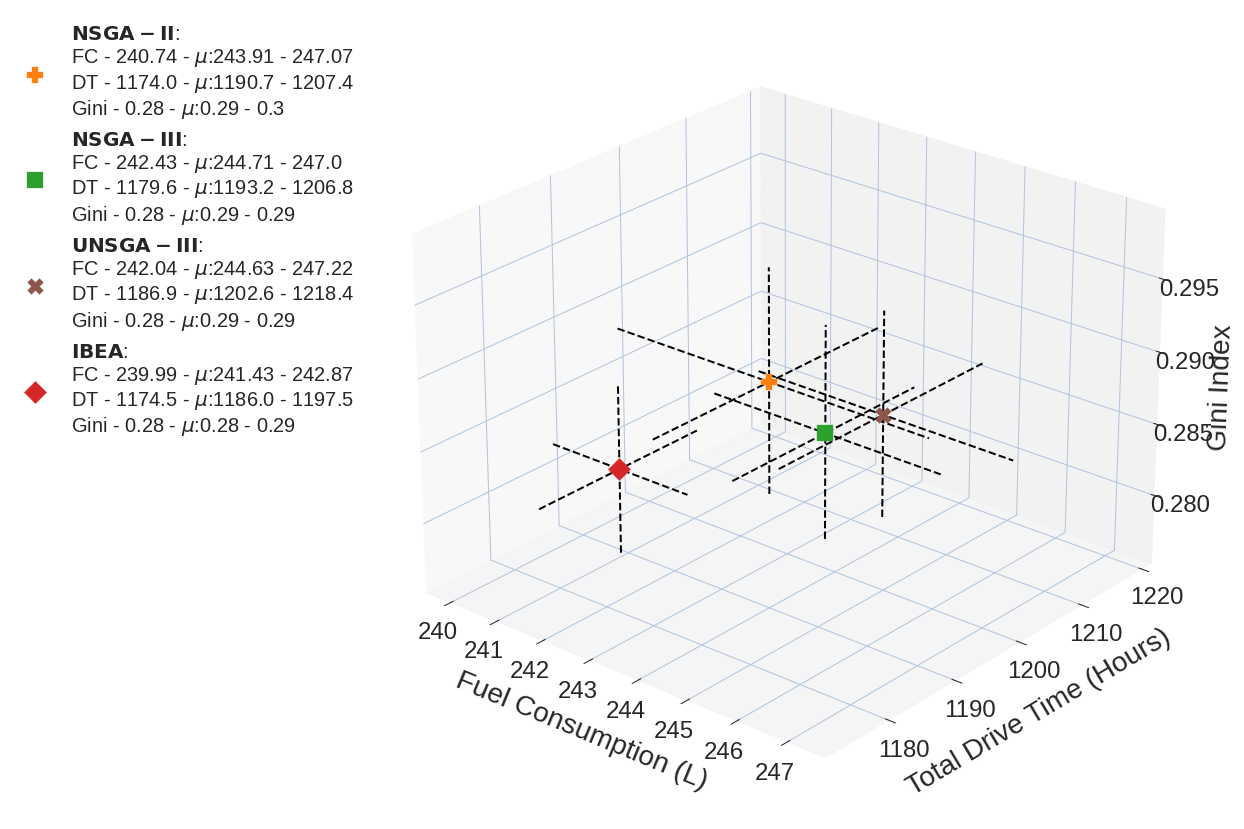

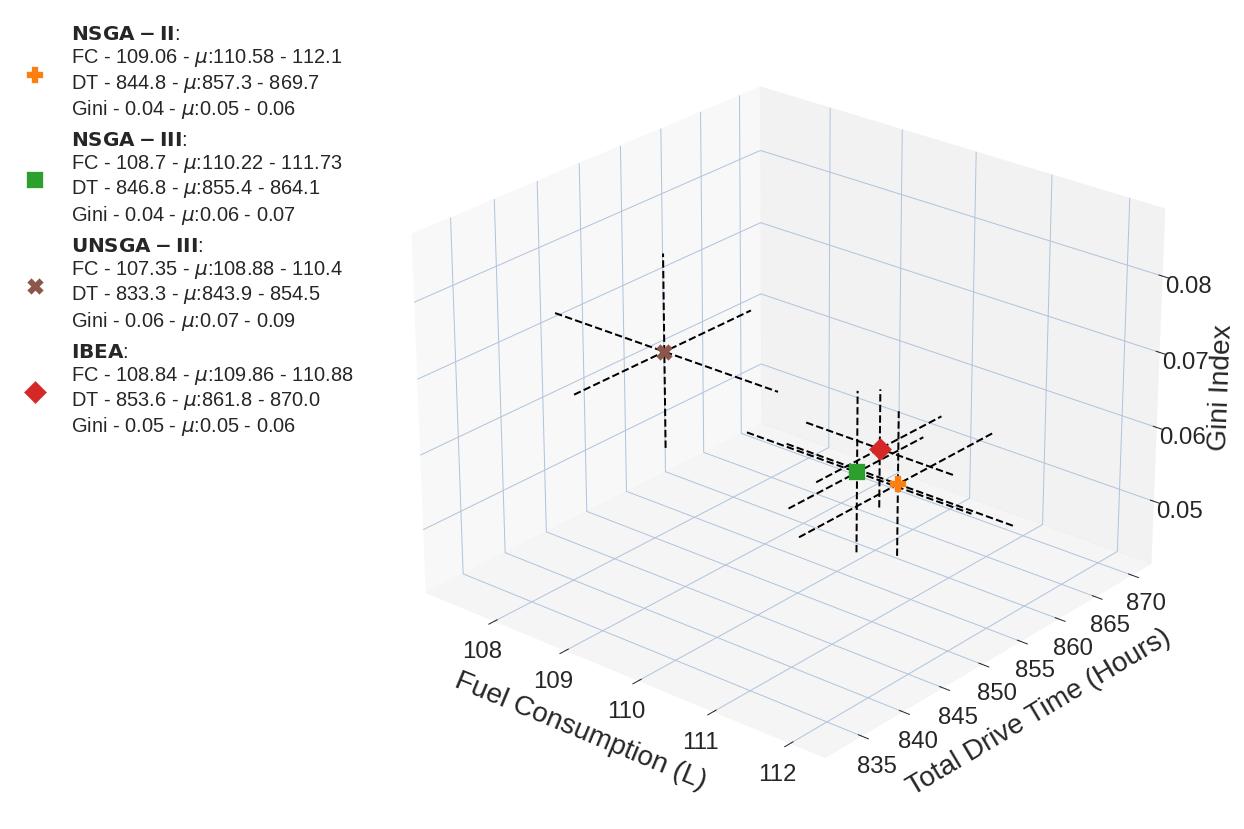

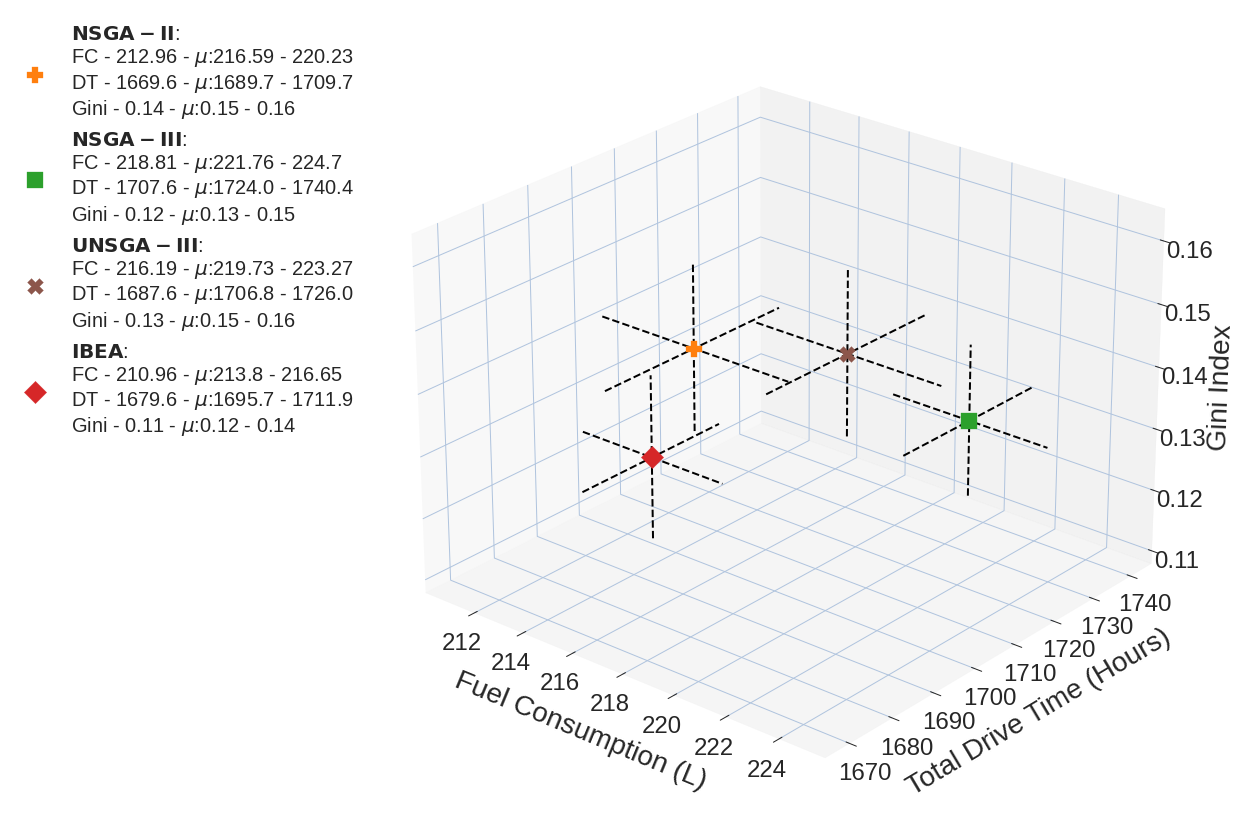

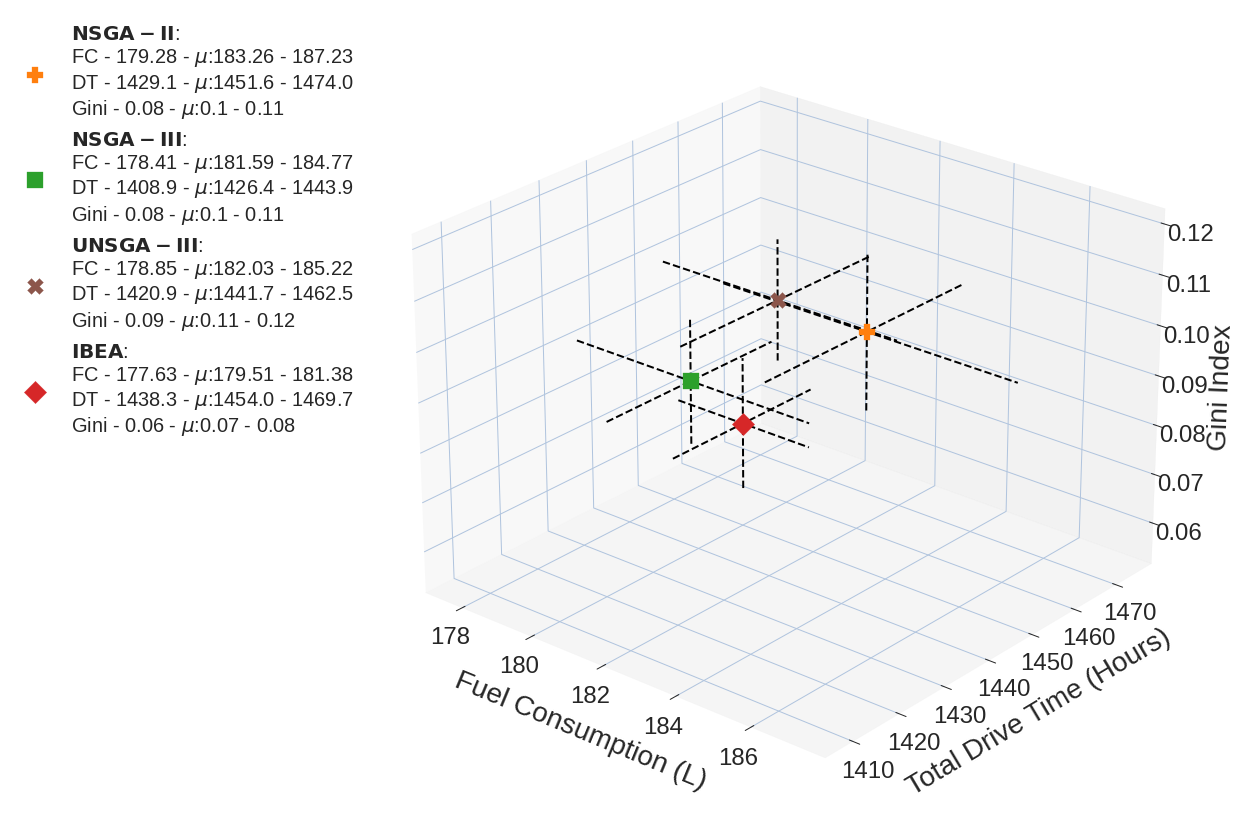

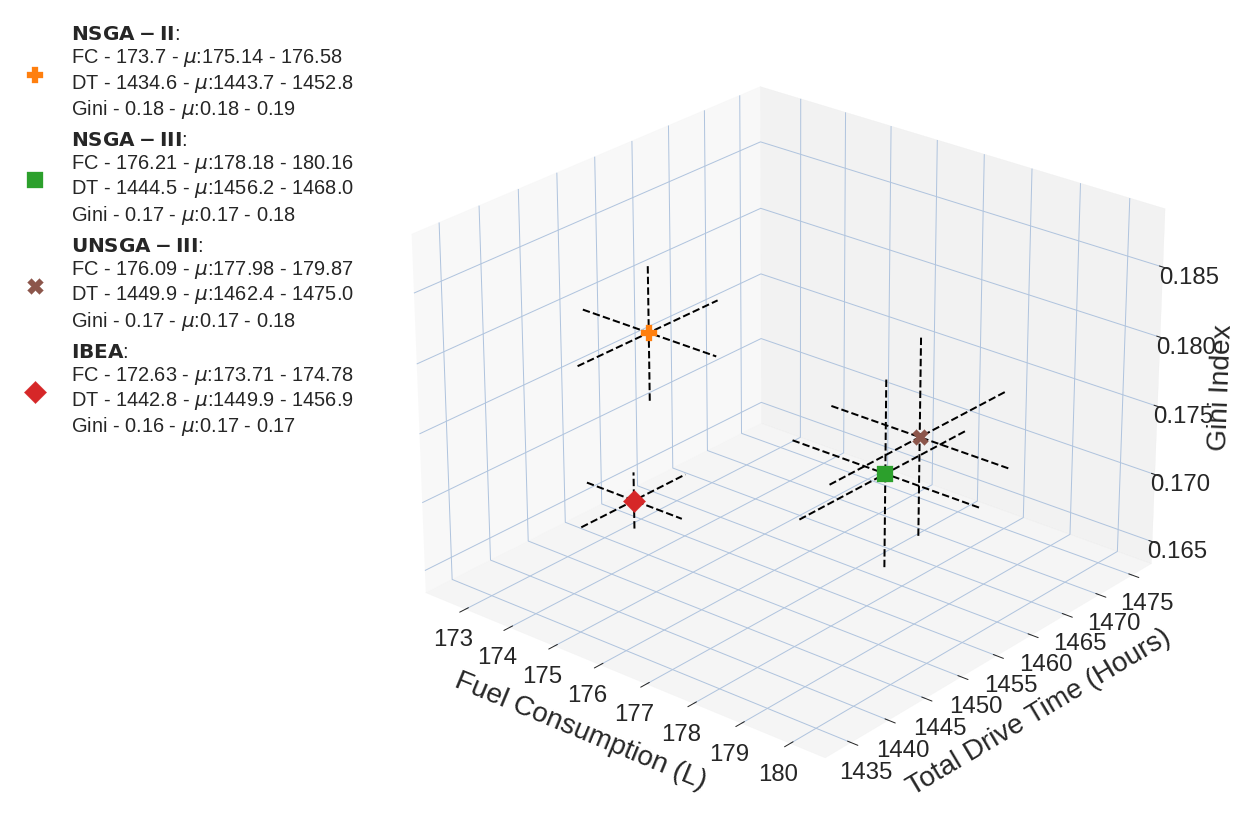

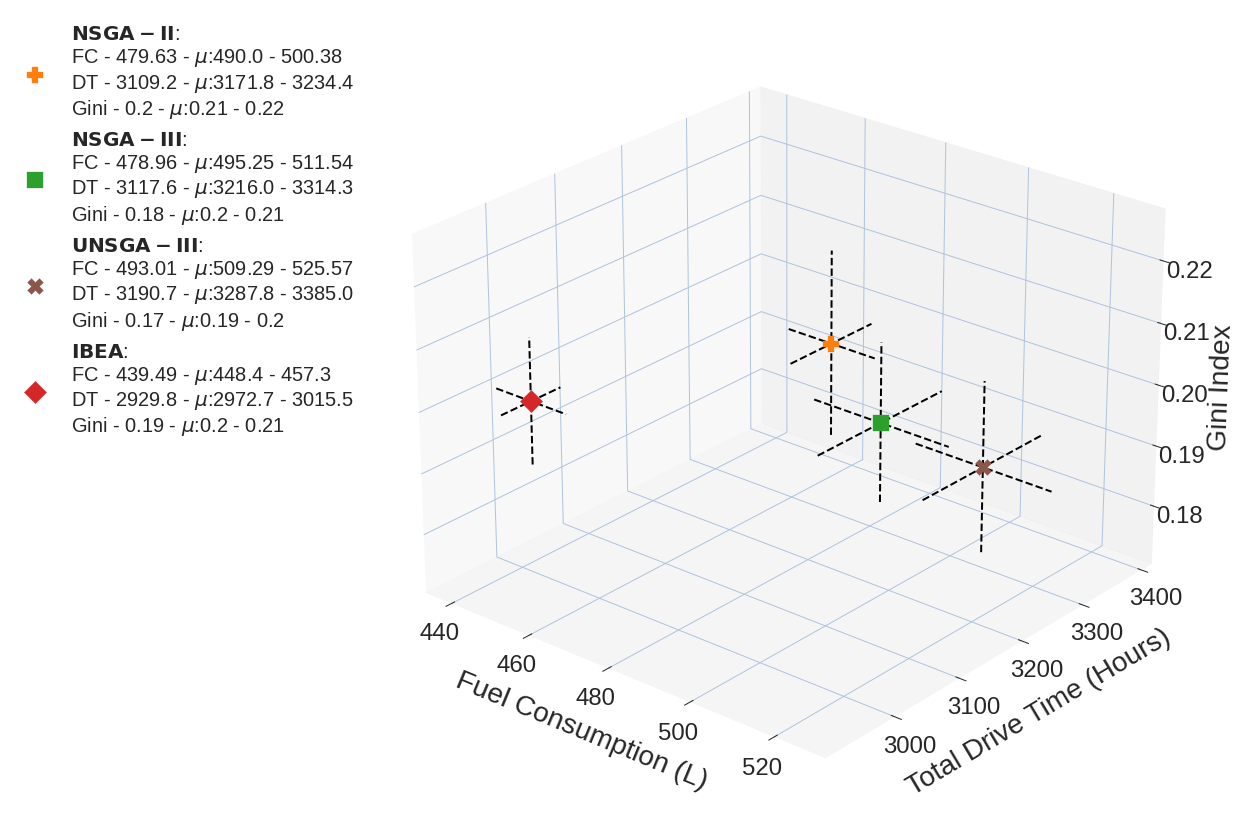

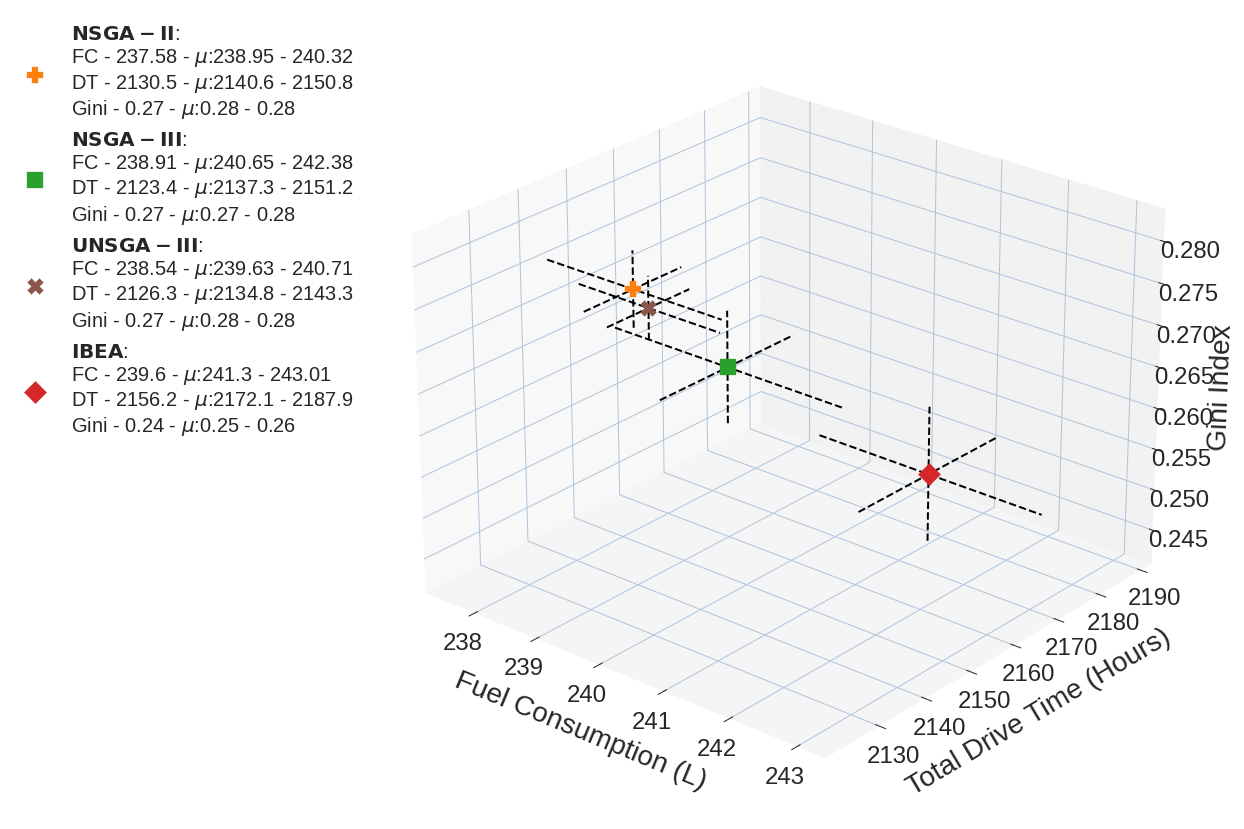

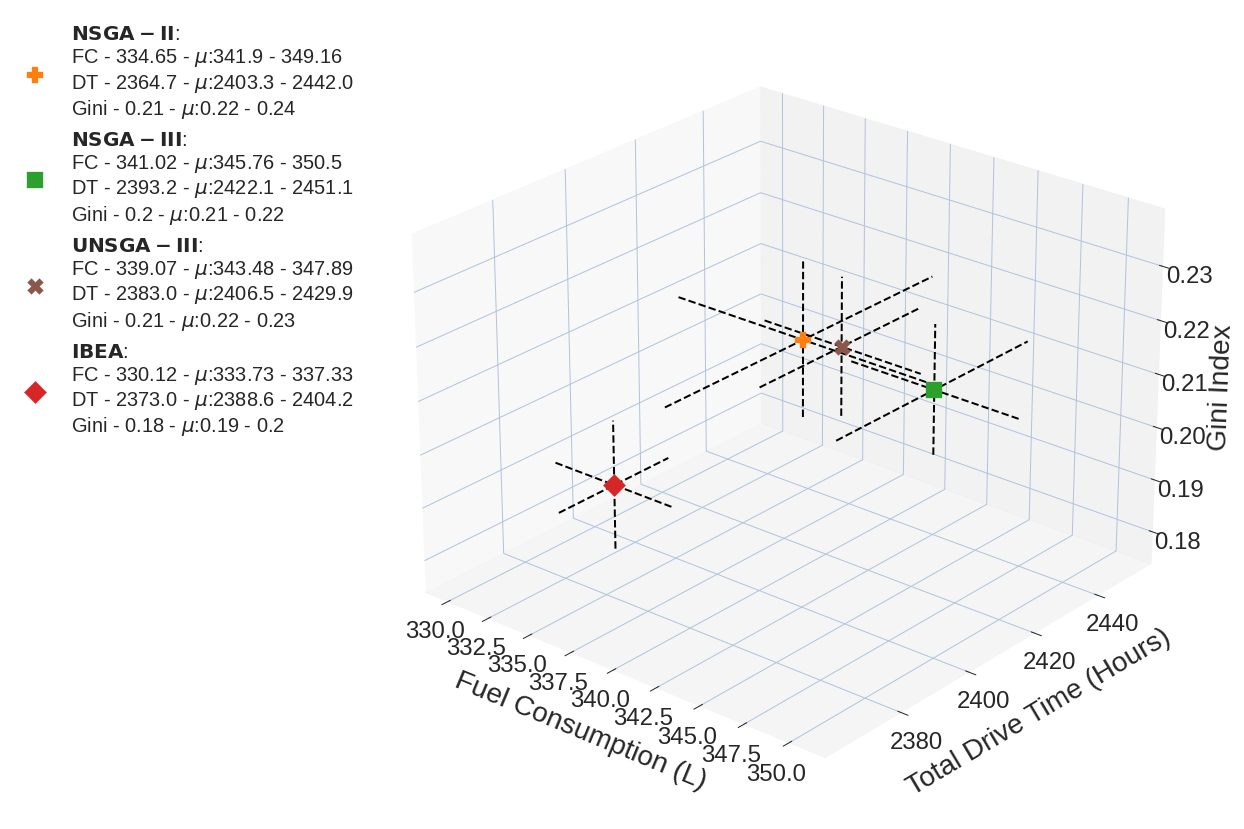

In [106]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
for dataset in dataset_names:
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    #print(NSGA2_data_dataset)
    algorithms = [NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset]
    
    labels = ["NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
    fig, ax = plot_3d_minmax(algorithms, labels,third_axis = "gini")
    plt.legend(bbox_to_anchor=(0, 1))
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Total Drive Time (Hours)",labelpad=24)
    ax.set_zlabel("Gini Index", labelpad=16)
    ax.view_init(elev=25,azim=-50)
    #plt.tight_layout(pad=2)
    plt.show()

In [107]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = [ "NSGA-II","NSGA-III","UNSGA-III","IBEA"]
correlations = {algo_name:[] for algo_name in algorithm_names}

for dataset in dataset_names:
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
   
    
    correlations["NSGA-II"].append(np.round(NSGA2_data_dataset.gini_mean,2))
    correlations["NSGA-III"].append(np.round(NSGA3_data_dataset.gini_mean,2))
    correlations["UNSGA-III"].append(np.round(UNSGA3_data_dataset.gini_mean,2))
    correlations["IBEA"].append(np.round(IBEA_data_dataset.gini_mean,2))
    
result_df = pd.DataFrame(correlations,index=[name[:-2] + "\\" + name[-2:] for name in dataset_names ])

min_pandas = result_df.min(1)

def f_tex(x):
    if x in min_pandas.values:
        return '\\textbf{' +f'{x:0.2f}'+ '}'
    else:
        return f'{x:0.2f}'

print(result_df.to_latex(column_format="lcccc",formatters=[f_tex]*len(result_df.columns),escape=False))
result_df.style.highlight_min(color = 'lightgreen', 
                       axis = 1)

\begin{tabular}{lcccc}
\toprule
{} &       NSGA-II &      NSGA-III &     UNSGA-III &          IBEA \\
\midrule
UK25\_2 &          0.04 &          0.04 &          0.04 & \textbf{0.03} \\
UK25\_4 &          0.29 &          0.29 &          0.29 & \textbf{0.28} \\
UK25\_8 & \textbf{0.05} &          0.06 & \textbf{0.07} & \textbf{0.05} \\
UK50\_1 &          0.15 &          0.13 &          0.15 & \textbf{0.12} \\
UK50\_2 &          0.10 &          0.10 &          0.11 & \textbf{0.07} \\
UK50\_4 &          0.18 & \textbf{0.17} & \textbf{0.17} & \textbf{0.17} \\
UK75\_1 &          0.21 &          0.20 & \textbf{0.19} &          0.20 \\
UK75\_3 & \textbf{0.28} &          0.27 & \textbf{0.28} & \textbf{0.25} \\
UK75\_6 &          0.22 &          0.21 &          0.22 & \textbf{0.19} \\
\bottomrule
\end{tabular}



,NSGA-II,NSGA-III,UNSGA-III,IBEA
UK25\_2,0.040000,0.040000,0.040000,0.030000
UK25\_4,0.290000,0.290000,0.290000,0.280000
UK25\_8,0.050000,0.060000,0.070000,0.050000
UK50\_1,0.150000,0.130000,0.150000,0.120000
UK50\_2,0.100000,0.100000,0.110000,0.070000
UK50\_4,0.180000,0.170000,0.170000,0.170000
UK75\_1,0.210000,0.200000,0.190000,0.200000
UK75\_3,0.280000,0.270000,0.280000,0.250000
UK75\_6,0.220000,0.210000,0.220000,0.190000


In [108]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = [ "NSGA-II","NSGA-III","UNSGA-III","IBEA"]
correlations = {algo_name:[] for algo_name in algorithm_names}

for dataset in dataset_names:
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()

    correlations["NSGA-II"].append(np.round(NSGA2_data_dataset.fuel_consumption_final,2))
    correlations["NSGA-III"].append(np.round(NSGA3_data_dataset.fuel_consumption_final,2))
    correlations["UNSGA-III"].append(np.round(UNSGA3_data_dataset.fuel_consumption_final,2))
    correlations["IBEA"].append(np.round(IBEA_data_dataset.fuel_consumption_final,2))
    
result_df = pd.DataFrame(correlations,index=[name[:-2] + "\\" + name[-2:] for name in dataset_names ])

min_pandas = result_df.min(1)

def f_tex(x):
    if x in min_pandas.values:
        return '\\textbf{' +f'{x:0.2f}'+ '}'
    else:
        return f'{x:0.2f}'

print(result_df.to_latex(column_format="lccccccc",formatters=[f_tex]*len(result_df.columns),escape=False))
result_df.style.highlight_min(color = 'lightgreen', 
                       axis = 1)

\begin{tabular}{lccccccc}
\toprule
{} &         NSGA-II &       NSGA-III &       UNSGA-III &            IBEA \\
\midrule
UK25\_2 &           71.90 & \textbf{71.78} &           73.08 &           72.76 \\
UK25\_4 &          243.91 &         244.71 &          244.63 & \textbf{241.43} \\
UK25\_8 &          110.58 &         110.22 & \textbf{108.88} &          109.86 \\
UK50\_1 &          216.59 &         221.76 &          219.73 & \textbf{213.80} \\
UK50\_2 &          183.26 &         181.59 &          182.03 & \textbf{179.51} \\
UK50\_4 &          175.14 &         178.18 &          177.98 & \textbf{173.71} \\
UK75\_1 &          490.00 &         495.25 &          509.29 & \textbf{448.40} \\
UK75\_3 & \textbf{238.95} &         240.65 &          239.63 &          241.30 \\
UK75\_6 &          341.90 &         345.76 &          343.48 & \textbf{333.73} \\
\bottomrule
\end{tabular}



,NSGA-II,NSGA-III,UNSGA-III,IBEA
UK25\_2,71.900000,71.780000,73.080000,72.760000
UK25\_4,243.910000,244.710000,244.630000,241.430000
UK25\_8,110.580000,110.220000,108.880000,109.860000
UK50\_1,216.590000,221.760000,219.730000,213.800000
UK50\_2,183.260000,181.590000,182.030000,179.510000
UK50\_4,175.140000,178.180000,177.980000,173.710000
UK75\_1,490.000000,495.250000,509.290000,448.400000
UK75\_3,238.950000,240.650000,239.630000,241.300000
UK75\_6,341.900000,345.760000,343.480000,333.730000


In [109]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = [ "NSGA-II","NSGA-III","UNSGA-III","IBEA"]
correlations = {algo_name:[] for algo_name in algorithm_names}

for dataset in dataset_names:
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()

    correlations["NSGA-II"].append(np.round(NSGA2_data_dataset.total_drive_time,2))
    correlations["NSGA-III"].append(np.round(NSGA3_data_dataset.total_drive_time,2))
    correlations["UNSGA-III"].append(np.round(UNSGA3_data_dataset.total_drive_time,2))
    correlations["IBEA"].append(np.round(IBEA_data_dataset.total_drive_time,2))
    
result_df = pd.DataFrame(correlations,index=[name[:-2] + "\\" + name[-2:] for name in dataset_names ])

min_pandas = result_df.min(1)

def f_tex(x):
    if x in min_pandas.values:
        return '\\textbf{' +f'{x:0.2f}'+ '}'
    else:
        return f'{x:0.2f}'

print(result_df.to_latex(column_format="lccccccc",formatters=[f_tex]*len(result_df.columns),escape=False))
result_df.style.highlight_min(color = 'lightgreen', 
                       axis = 1)

\begin{tabular}{lccccccc}
\toprule
{} &          NSGA-II &         NSGA-III &        UNSGA-III &             IBEA \\
\midrule
UK25\_2 &           554.72 &  \textbf{550.06} &           558.45 &           560.76 \\
UK25\_4 &          1190.70 &          1193.16 &          1202.61 & \textbf{1185.99} \\
UK25\_8 &           857.27 &           855.45 &  \textbf{843.88} &           861.82 \\
UK50\_1 & \textbf{1689.65} &          1724.03 &          1706.77 &          1695.74 \\
UK50\_2 &          1451.56 & \textbf{1426.40} &          1441.75 &          1454.01 \\
UK50\_4 & \textbf{1443.68} &          1456.22 &          1462.44 &          1449.88 \\
UK75\_1 &          3171.80 &          3215.95 &          3287.82 & \textbf{2972.66} \\
UK75\_3 &          2140.61 &          2137.28 & \textbf{2134.82} &          2172.07 \\
UK75\_6 &          2403.33 &          2422.14 &          2406.47 & \textbf{2388.62} \\
\bottomrule
\end{tabular}



,NSGA-II,NSGA-III,UNSGA-III,IBEA
UK25\_2,554.720000,550.060000,558.450000,560.760000
UK25\_4,1190.700000,1193.160000,1202.610000,1185.990000
UK25\_8,857.270000,855.450000,843.880000,861.820000
UK50\_1,1689.650000,1724.030000,1706.770000,1695.740000
UK50\_2,1451.560000,1426.400000,1441.750000,1454.010000
UK50\_4,1443.680000,1456.220000,1462.440000,1449.880000
UK75\_1,3171.800000,3215.950000,3287.820000,2972.660000
UK75\_3,2140.610000,2137.280000,2134.820000,2172.070000
UK75\_6,2403.330000,2422.140000,2406.470000,2388.620000


In [110]:
dataset_names =  ["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]
algorithm_names = [ "NSGA-II","NSGA-III","UNSGA-III","IBEA"]
correlations = {algo_name:[] for algo_name in algorithm_names}

for dataset in dataset_names:
    NSGA2_data_dataset = NSGA2_data_evaluation_limited.where(NSGA2_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_evaluation_limited.where(NSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_evaluation_limited.where(UNSGA3_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_evaluation_limited.where(IBEA_data_evaluation_limited.dataset == dataset).dropna(how="all").mean()

    correlations["NSGA-II"].append(np.round(NSGA2_data_dataset.vehicle_amount,2))
    correlations["NSGA-III"].append(np.round(NSGA3_data_dataset.vehicle_amount,2))
    correlations["UNSGA-III"].append(np.round(UNSGA3_data_dataset.vehicle_amount,2))
    correlations["IBEA"].append(np.round(IBEA_data_dataset.vehicle_amount,2))
    
result_df = pd.DataFrame(correlations,index=[name[:-2] + "\\" + name[-2:] for name in dataset_names ])

min_pandas = result_df.min(1)

def f_tex(x):
    if x in min_pandas.values:
        return '\\textbf{' +f'{x:0.2f}'+ '}'
    else:
        return f'{x:0.2f}'

print(result_df.to_latex(column_format="lccccccc",formatters=[f_tex]*len(result_df.columns),escape=False))
result_df.style.highlight_min(color = 'lightgreen', 
                       axis = 1)

\begin{tabular}{lccccccc}
\toprule
{} &       NSGA-II &       NSGA-III &     UNSGA-III &           IBEA \\
\midrule
UK25\_2 &          3.07 &  \textbf{3.00} &          3.03 &           3.07 \\
UK25\_4 &          5.03 &  \textbf{5.00} &          5.03 &  \textbf{5.00} \\
UK25\_8 & \textbf{3.93} &           4.00 &          4.00 &           4.00 \\
UK50\_1 &          9.00 &           9.23 & \textbf{8.97} &           9.33 \\
UK50\_2 &          6.30 &  \textbf{6.27} &          6.43 &           6.30 \\
UK50\_4 &          8.03 &  \textbf{8.00} &          8.03 &  \textbf{8.00} \\
UK75\_1 &         10.50 &          10.57 &         10.53 &  \textbf{9.43} \\
UK75\_3 &         12.40 & \textbf{12.13} &         12.33 &          12.80 \\
UK75\_6 &         11.87 & \textbf{12.13} &         12.03 & \textbf{11.67} \\
\bottomrule
\end{tabular}



,NSGA-II,NSGA-III,UNSGA-III,IBEA
UK25\_2,3.070000,3.000000,3.030000,3.070000
UK25\_4,5.030000,5.000000,5.030000,5.000000
UK25\_8,3.930000,4.000000,4.000000,4.000000
UK50\_1,9.000000,9.230000,8.970000,9.330000
UK50\_2,6.300000,6.270000,6.430000,6.300000
UK50\_4,8.030000,8.000000,8.030000,8.000000
UK75\_1,10.500000,10.570000,10.530000,9.430000
UK75\_3,12.400000,12.130000,12.330000,12.800000
UK75\_6,11.870000,12.130000,12.030000,11.670000


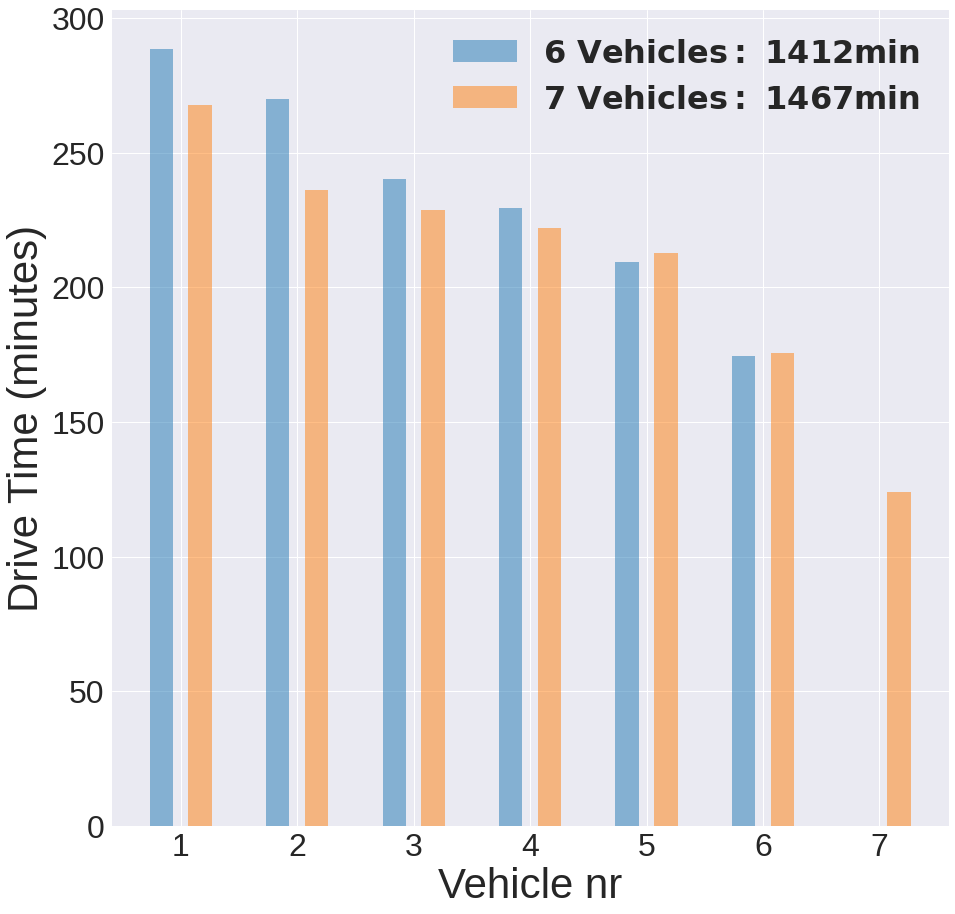

In [124]:
plot_vehicle_drivetimes(NSGA3_data_evaluation_limited,"UK50_2")